# TorchVision Object Detection Finetuning Tutorial

[Kaggle: Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection/)

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

## Prepare Dataset

Download the dataset from Kaggle `data` and list its contents:

In [2]:
!tree global-wheat-detection -L 1

global-wheat-detection
├── sample_submission.csv
├── test
├── train
└── train.csv

2 directories, 2 files


- train.csv - the training data
- sample_submission.csv - a sample submission file in the correct format
- train.zip - training images
- test.zip - test images

In [3]:
DIR_INPUT = 'global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

### Read Dataset

Read the `train.csv` data:

In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


- image_id - the unique image ID
- width, height - the width and height of the images
- bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
- etc.

Split`bbox` to `x` `y` `w` `h`:

In [5]:
train_df[['x','y','w','h']] = 0
train_df[['x','y','w','h']] = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=','))).astype(np.float)
train_df.drop(columns=['bbox'], inplace=True)
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


### Analysis Dataset

The size of train data:

In [6]:
train_df.shape

(147793, 8)

The number of unique `image_id` in train data:

In [7]:
train_df['image_id'].nunique()

3373

The number of images in train dir:

In [8]:
len(os.listdir(DIR_TRAIN))

3423

There are `3422-3373=49` images which do not have any wheat heads in it (without annotation). 

Distribution of size of train images:

In [9]:
train_df['width'].unique(), train_df['height'].unique()

(array([1024]), array([1024]))

Distribution of number of bounding boxes:

# of boxes, range [1, 116]


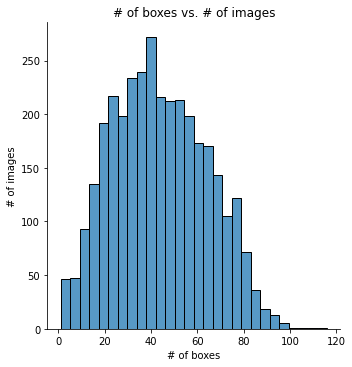

In [10]:
counts = train_df['image_id'].value_counts()
print(f'# of boxes, range [{min(counts)}, {max(counts)}]')
sns.displot(counts, kde=False)
plt.xlabel('# of boxes')
plt.ylabel('# of images')
plt.title('# of boxes vs. # of images')
plt.show()

Distribution of size of bounding boxes:

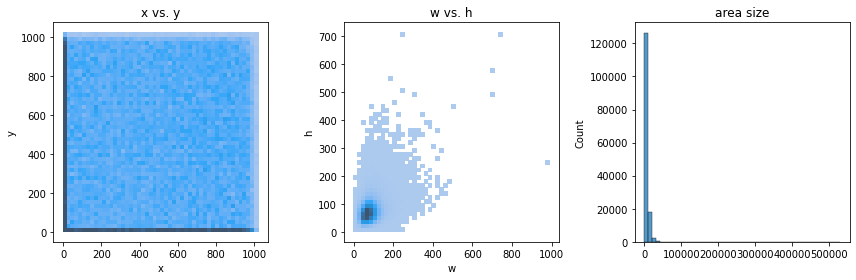

In [11]:
ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)[1].ravel()
ax[0].set_title('x vs. y')
ax[1].set_title('w vs. h')
ax[2].set_title('area size')
sns.histplot(train_df[['x', 'y']], x='x', y='y', ax=ax[0], bins=50, pmax=0.9)
sns.histplot(train_df[['w', 'h']], x='w', y='h', ax=ax[1], bins=50, pmax=0.9)
sns.histplot(train_df['w'] * train_df['h'], ax=ax[2], bins=50, kde=False)
plt.show()

Split dataset to `train:valid=8:2`:

In [12]:
image_ids = train_df['image_id'].unique()

split_len = round(len(image_ids)*0.8)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = train_df[train_df['image_id'].isin(train_ids)]
valid = train_df[train_df['image_id'].isin(valid_ids)]

train.shape, valid.shape

((122577, 8), (25216, 8))

### Visualize Images

In [13]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

# https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py

Show images without `bboxes`:

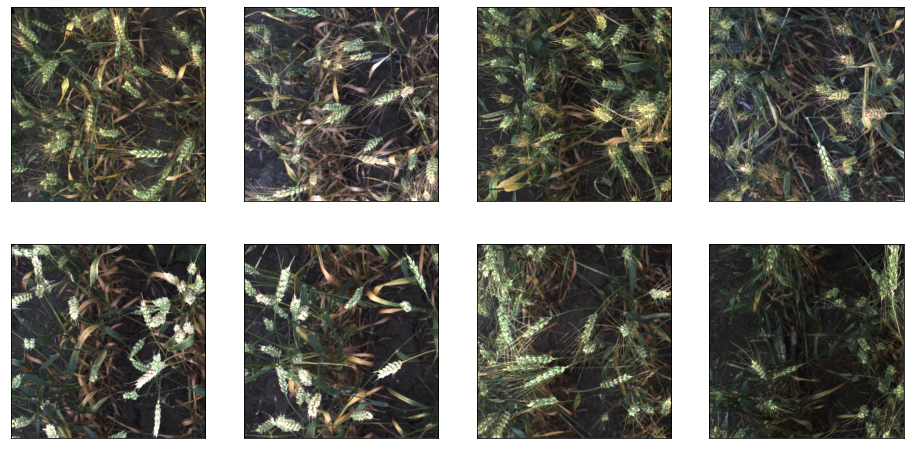

In [14]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{DIR_TRAIN}/{n}.jpg') for n in train_df['image_id'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

Show images with `bboxes`:

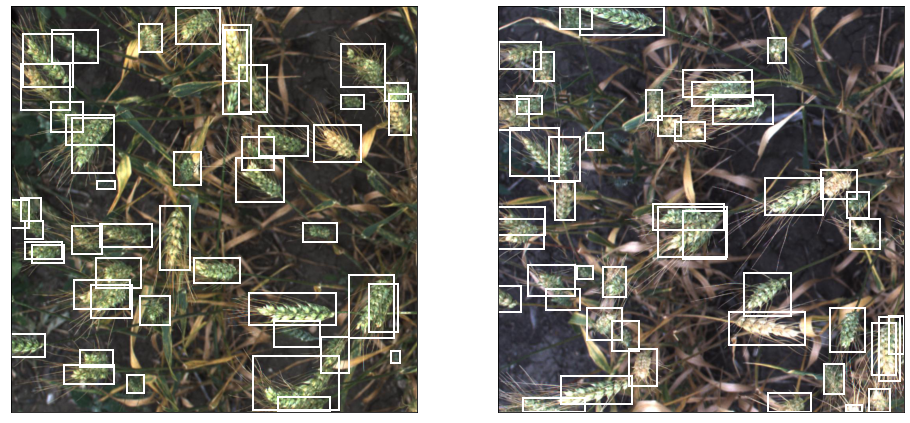

In [15]:
num_rows, num_cols = 1, 2
ids = train_df['image_id'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{DIR_TRAIN}/{n}.jpg') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = train_df[train_df['image_id'] == id]
  bboxes = [(d['x'], d['y'], d['x']+d['w'], d['y']+d['h']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

### Create Dataset

The dataset should inherit from the standard [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a `numpy.ndarray` image
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.

In [16]:
import cv2 as cv
import numpy as np

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset


class Wheat(Dataset):

  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()
    self.image_ids = dataframe['image_id'].unique()
    self.df = dataframe
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]
    records = self.df[self.df['image_id'] == image_id]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    boxes = records[['x', 'y', 'w', 'h']].values

    area = boxes[:, 2] * boxes[:, 3]
    area = torch.as_tensor(area, dtype=torch.float32)

    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    # there is only one class
    labels = torch.ones((records.shape[0],), dtype=torch.int64)
    # suppose all instances are not crowd
    iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([idx])
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms:
      sample = {
        'image': image,
        'bboxes': target['boxes'],
        'labels': labels,
      }
      sample = self.transforms(**sample)
      image = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

    return image, target, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  # albumentations
  #  https://github.com/albumentations-team/albumentations

  @staticmethod
  def get_train_transform():
    return A.Compose([
      A.Flip(0.5),
      ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

  @staticmethod
  def get_valid_transform():
    return A.Compose([
      ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Create `train` `valid` datasets:

In [17]:
train_dataset = Wheat(train, DIR_TRAIN, Wheat.get_train_transform())
valid_dataset = Wheat(valid, DIR_TRAIN, Wheat.get_valid_transform())

Show images with `transforms`:

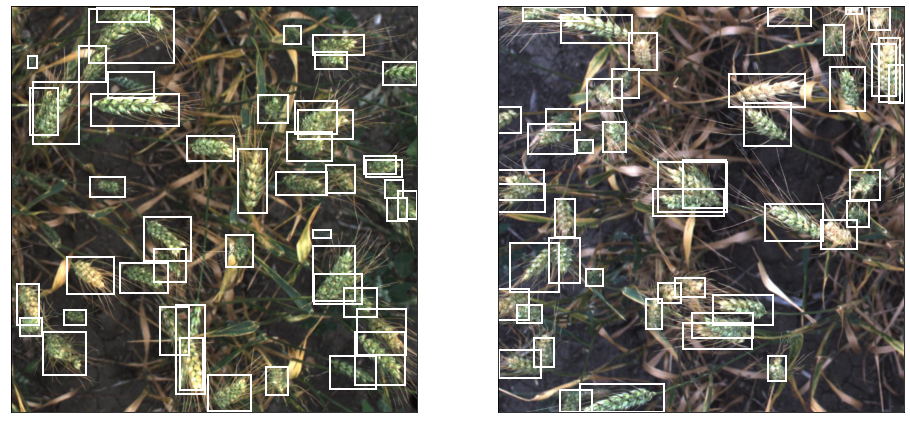

In [18]:
datas = [train_dataset[i] for i in range(2)]
imgs = [d[0].permute(1, 2, 0).numpy() for d in datas]
axes = show_images(imgs, 1, 2, scale=8)
for ax, (image, target, image_id) in zip(axes, datas):
  show_bboxes(ax, target['boxes'], labels=None, colors=['w'])
plt.show()

## Create Model

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [21]:
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)


In [22]:
num_classes = 2 # wheat or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [23]:
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


## Train Model

In [24]:
from torch.utils.data import DataLoader

In [25]:
class Averager:
  def __init__(self):
    self.current_total = 0.0
    self.iterations = 0.0

  def send(self, value):
    self.current_total += value
    self.iterations += 1

  @property
  def value(self):
    if self.iterations == 0:
      return 0
    else:
      return 1.0 * self.current_total / self.iterations

  def reset(self):
    self.current_total = 0.0
    self.iterations = 0.0

In [26]:
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

def collate_fn(batch):
  return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=16,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=8,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

In [27]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [28]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
  loss_hist.reset()

  for images, targets, image_ids in train_data_loader:

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # set loss function
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    loss_hist.send(loss_value)

    # set parameters
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    # display option
    if itr % 50 == 0:
      print(f"Iteration #{itr} loss: {loss_value}")

    itr += 1

  # learning rate scheduler
  if lr_scheduler is not None:
    lr_scheduler.step()

  print(f"Epoch #{epoch} loss: {loss_hist.value}")

## References

- [TorchVision Instance Segmentation Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
- [Kaggle: Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection)
  - [Pytorch Starter - FasterRCNN Train](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)
  - [Global Wheat Detection: Starter EDA](https://www.kaggle.com/kaushal2896/global-wheat-detection-starter-eda)